<a href="https://colab.research.google.com/github/greyhound101/brats/blob/main/brats_7e5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
pip install medpy

     |████████████████████████████████| 153kB 7.5MB/s 
     |████████████████████████████████| 47.4MB 60kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754476 sha256=3eab2d5187c18e4217e8f0fe241b746190f3229bf6e8c4676931f6119ef68764
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [3]:
import numpy as np
images=np.load('/content/gdrive/MyDrive/Brats2d/images.npy')
targets=np.load('/content/gdrive/MyDrive/Brats2d/targets.npy')

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images,targets, test_size=0.33, random_state=42)

In [5]:
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import backend as K
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape
class abc(keras.layers.Layer):
    def __init__(self,
                 hidden_dim,
                 **kwargs):
        self.hidden_dim = hidden_dim
        
        self.conv1=Conv1D(self.hidden_dim,1)
        self.conv2=Conv1D(self.hidden_dim,1)
        self.conv3=Conv1D(self.hidden_dim,1)
        
        self.Wq = self.Wk = self.Wv = self.Wo = None
        self.bq = self.bk = self.bv = self.bo = None

        self.intensity = self.attention = None
        super(abc, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        
        q, k, v = inputs
        
        q=self.conv1(q)
        k=self.conv2(k)
        v=self.conv3(v)
        
        
        def scaled_dot_product_attention(inputs):
          query, key, value = inputs
          feature_dim = K.shape(query)[-1]
          e = K.batch_dot(query, key, axes=2) 
          intensity = e
          e = K.exp(e - K.max(e, axis=-1, keepdims=True))
          attention = e / K.sum(e, axis=-1, keepdims=True)
          v = K.batch_dot(attention, value)
          return v
       
       
        y = scaled_dot_product_attention(inputs=[q,k,v])
        
        
        return y

from tensorflow import keras 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
def load_model():   
  
  K.clear_session() 
  mod=densenet.DenseNet121(include_top=True, weights='imagenet')
  d = mod.get_layer('conv5_block16_concat').output

  inp = mod.get_layer('conv3_block12_concat').output
  a = Reshape((28*28,512))(inp)
  d_a = keras.layers.UpSampling2D(interpolation='bilinear',size=(4,4))(d)
  d_a = Reshape((28*28,1024))(d_a)
  a = abc(hidden_dim=512)([a,d_a,a])
  a = LayerNormalization()(a)
  a = Reshape((28,28,512,))(a)
  a = keras.layers.GlobalAveragePooling2D()(a)

  inp = mod.get_layer('conv4_block24_concat').output
  b = Reshape((14*14,1024))(inp)
  d_b = keras.layers.UpSampling2D(interpolation='bilinear',size=(2,2))(d)
  d_b = Reshape((14*14,1024))(d_b)
  b = abc(hidden_dim=1024)([b,d_b,b])
  b = LayerNormalization()(b)
  b = Reshape((14,14,1024,))(b)
  b = keras.layers.GlobalAveragePooling2D()(b)

  d = keras.layers.GlobalAveragePooling2D()(d)
  

  b = Dense(3, activation="softmax")(b) 
  b = Reshape((-1,3))(b) 
  a = Dense(3, activation="softmax")(a) 
  a = Reshape((-1,3))(a) 
  d = Dense(3, activation="softmax")(d) 
  d = Reshape((-1,3))(d) 
  
  conc=Concatenate(axis=1)([a,b,d])
  conc=keras.layers.GlobalAveragePooling1D()(conc)
  mod=Model(inputs=mod.input,outputs=conc)
#   mod.load_weights('../input/global-3535-fold-1-1/weights.hdf5')
#   for layer in mod.layers:
#     layer.trainable=False
  a=mod.layers[-9].output
  b=mod.layers[-10].output
  d=mod.layers[-11].output
  b = Dense(1, activation="sigmoid")(b) 
  b = Reshape((-1,1))(b) 
  a = Dense(1, activation="sigmoid")(a) 
  a = Reshape((-1,1))(a) 
  d = Dense(1, activation="sigmoid")(d) 
  d = Reshape((-1,1))(d) 
  conc=Concatenate(axis=1)([a,b,d])
  conc=keras.layers.GlobalAveragePooling1D()(conc)
  mod=Model(inputs=mod.input,outputs=conc)
  return mod

mod=load_model()

33193984/33188688 [==============================] - 0s 0us/step


In [6]:


from imgaug import augmenters as iaa
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
def Hflip( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)
def Vflip( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)
def noise(images):
    ls=[]
    for i in images:
        x = np.random.normal(loc=0, scale=0.05, size=(299,299,3))
        ls.append(i+x)
    return ls
def rotate(images):
    ls=[]
    for angle in range(-15,20,5):
        for image in images:
            ls.append(rotate_image(image,angle))
    return ls

class DataGenerator(keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=[]
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    lbl=labels.copy()
    labels=np.repeat(labels,9)
    del([imgV,imgR,imgH,lbl])
    gc.collect()
    #images = np.array([preprocess_input(img) for img in images])
    return np.asarray(images).astype('float16'), labels.astype('uint8')




In [7]:
import cv2
import gc
from tensorflow.keras.optimizers import *
train_data = DataGenerator(X_train,y_train, batch_size=4, augment=True)
mod.compile(optimizer=Adam(7e-5), loss='binary_crossentropy', metrics=['accuracy'])
hist=mod.fit_generator(train_data,epochs=50)
gc.collect()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
81/81 [==============================] - 73s 348ms/step - loss: 0.6969 - accuracy: 0.5130
Epoch 2/50
81/81 [==============================] - 29s 349ms/step - loss: 0.6832 - accuracy: 0.5521
Epoch 3/50
81/81 [==============================] - 29s 350ms/step - loss: 0.6799 - accuracy: 0.5823
Epoch 4/50
81/81 [==============================] - 29s 356ms/step - loss: 0.6703 - accuracy: 0.5971
Epoch 5/50
81/81 [==============================] - 29s 353ms/step - loss: 0.6582 - accuracy: 0.6139
Epoch 6/50
81/81 [==============================] - 29s 355ms/step - loss: 0.6335 - accuracy: 0.6598
Epoch 7/50
81/81 [==============================] - 28s 347ms/step - loss: 0.6071 - accuracy: 0.7095
Epoch 8/50
81/81 [==============================] - 29s 349ms/step - loss: 0.5829 - accuracy: 0.7435
Epoch 9/50
81/81 [==============================] - 28s 346ms/step - loss: 0.5506 - accuracy: 0.7966
Epoch 10/50
81/81 [==============================] - 28s 343ms/step - loss: 0.5789 - accura

0

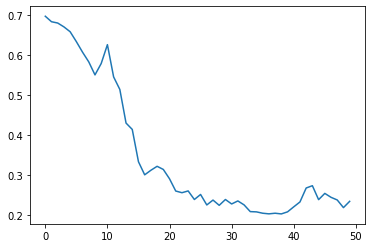

In [8]:
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])

In [9]:
pre=mod.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(np.round(pre),y_test)

0.5962732919254659